In [3]:
import mne
import copy
import scipy.signal.windows

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dtw import dtw
from alphacsc import BatchCDL

from functions import display_atoms, display_ffts, display_topomap
from mne_data import load_data

The paper imposes a rank-1 constraint over the dictionary of patterns $D$. This constraint facilitates the optimization of the problem transforming it from multivariate to a two-step univariate by changing the computation of the gradient over a $C \times P$ matrix to over two univariate arrays $u_k \in \mathbb{R}^C$ and $v_k \in \mathbb{R}^P$.

The final problems turns into
(equation)

which is marginally convex on each variable $v_k$ and $u_k$, and can be solved by a normal projected gradient descent.

This constraint, however, imposes an implicit hypothesis that, at each time, you can consider that there is a single source region on the brain which generates the signal, that is then reproduced in all other locations of the brain with different intensities.


In [10]:
# Let us first define the parameters of our model.

sfreq = 150.

# Define the shape of the dictionary
n_atoms = 25
n_times_atom = int(round(sfreq * 1.0))  # 1000. ms


In [11]:
# Next, we define the parameters for multivariate CSC

# Monkey-patch scipy.signal.tukey to point to the correct function
scipy.signal.tukey = scipy.signal.windows.tukey

cdl = BatchCDL(
    # Shape of the dictionary
    n_atoms=n_atoms,
    n_times_atom=n_times_atom,
    # Request a rank1 dictionary with unit norm temporal and spatial maps
    rank1=True, uv_constraint='separate',
    # Initialize the dictionary with random chunk from the data
    D_init='chunk',
    # rescale the regularization parameter to be 20% of lambda_max
    lmbd_max="scaled", reg=.2,
    # Number of iteration for the alternate minimization and cvg threshold
    n_iter=100, eps=1e-4,
    # solver for the z-step
    solver_z="lgcd", solver_z_kwargs={'tol': 1e-2, 'max_iter': 1000},
    # solver for the d-step
    solver_d='alternate_adaptive', solver_d_kwargs={'max_iter': 300},
    # Technical parameters
    verbose=1, random_state=0, n_jobs=6)



Now, he can chose two regions of the brain that are the most uncorrelated. We can do that by computing the correlation matrix between two regions and separating channels based on the regions of bigger correlation.

In [12]:
# Here, we load the data from the somato-sensory dataset and preprocess them
# in epochs. The epochs are selected around the stim, starting 2 seconds
# before and finishing 4 seconds after.

t_lim = (-2, 4)

X, info= load_data(dataset='somato', epoch=t_lim, sfreq=sfreq)

# Separate the channels that are more correlated on two groups
n_split = 110
n_channels = len(info['ch_names'])

all_channels = info['ch_names']
channels_1 = all_channels[:n_split] + ['STI 014']
channels_2 = all_channels[n_split:] + ['STI 014']

X1, info1= load_data(dataset='somato', epoch=t_lim, sfreq=sfreq,channels=channels_1)
X2, info2= load_data(dataset='somato', epoch=t_lim, sfreq=sfreq,channels=channels_2)


First, let's see the atoms found when all data is used for solving the optimization problem

In [13]:
# Learn rank-1 atoms
cdl_all = copy.deepcopy(cdl)
cdl_all.fit(X)

.............
[BatchCDL] Converged after 13 iteration, (dz, du) = 9.557e-05, 9.320e-05
[BatchCDL] Fit in 224.9s


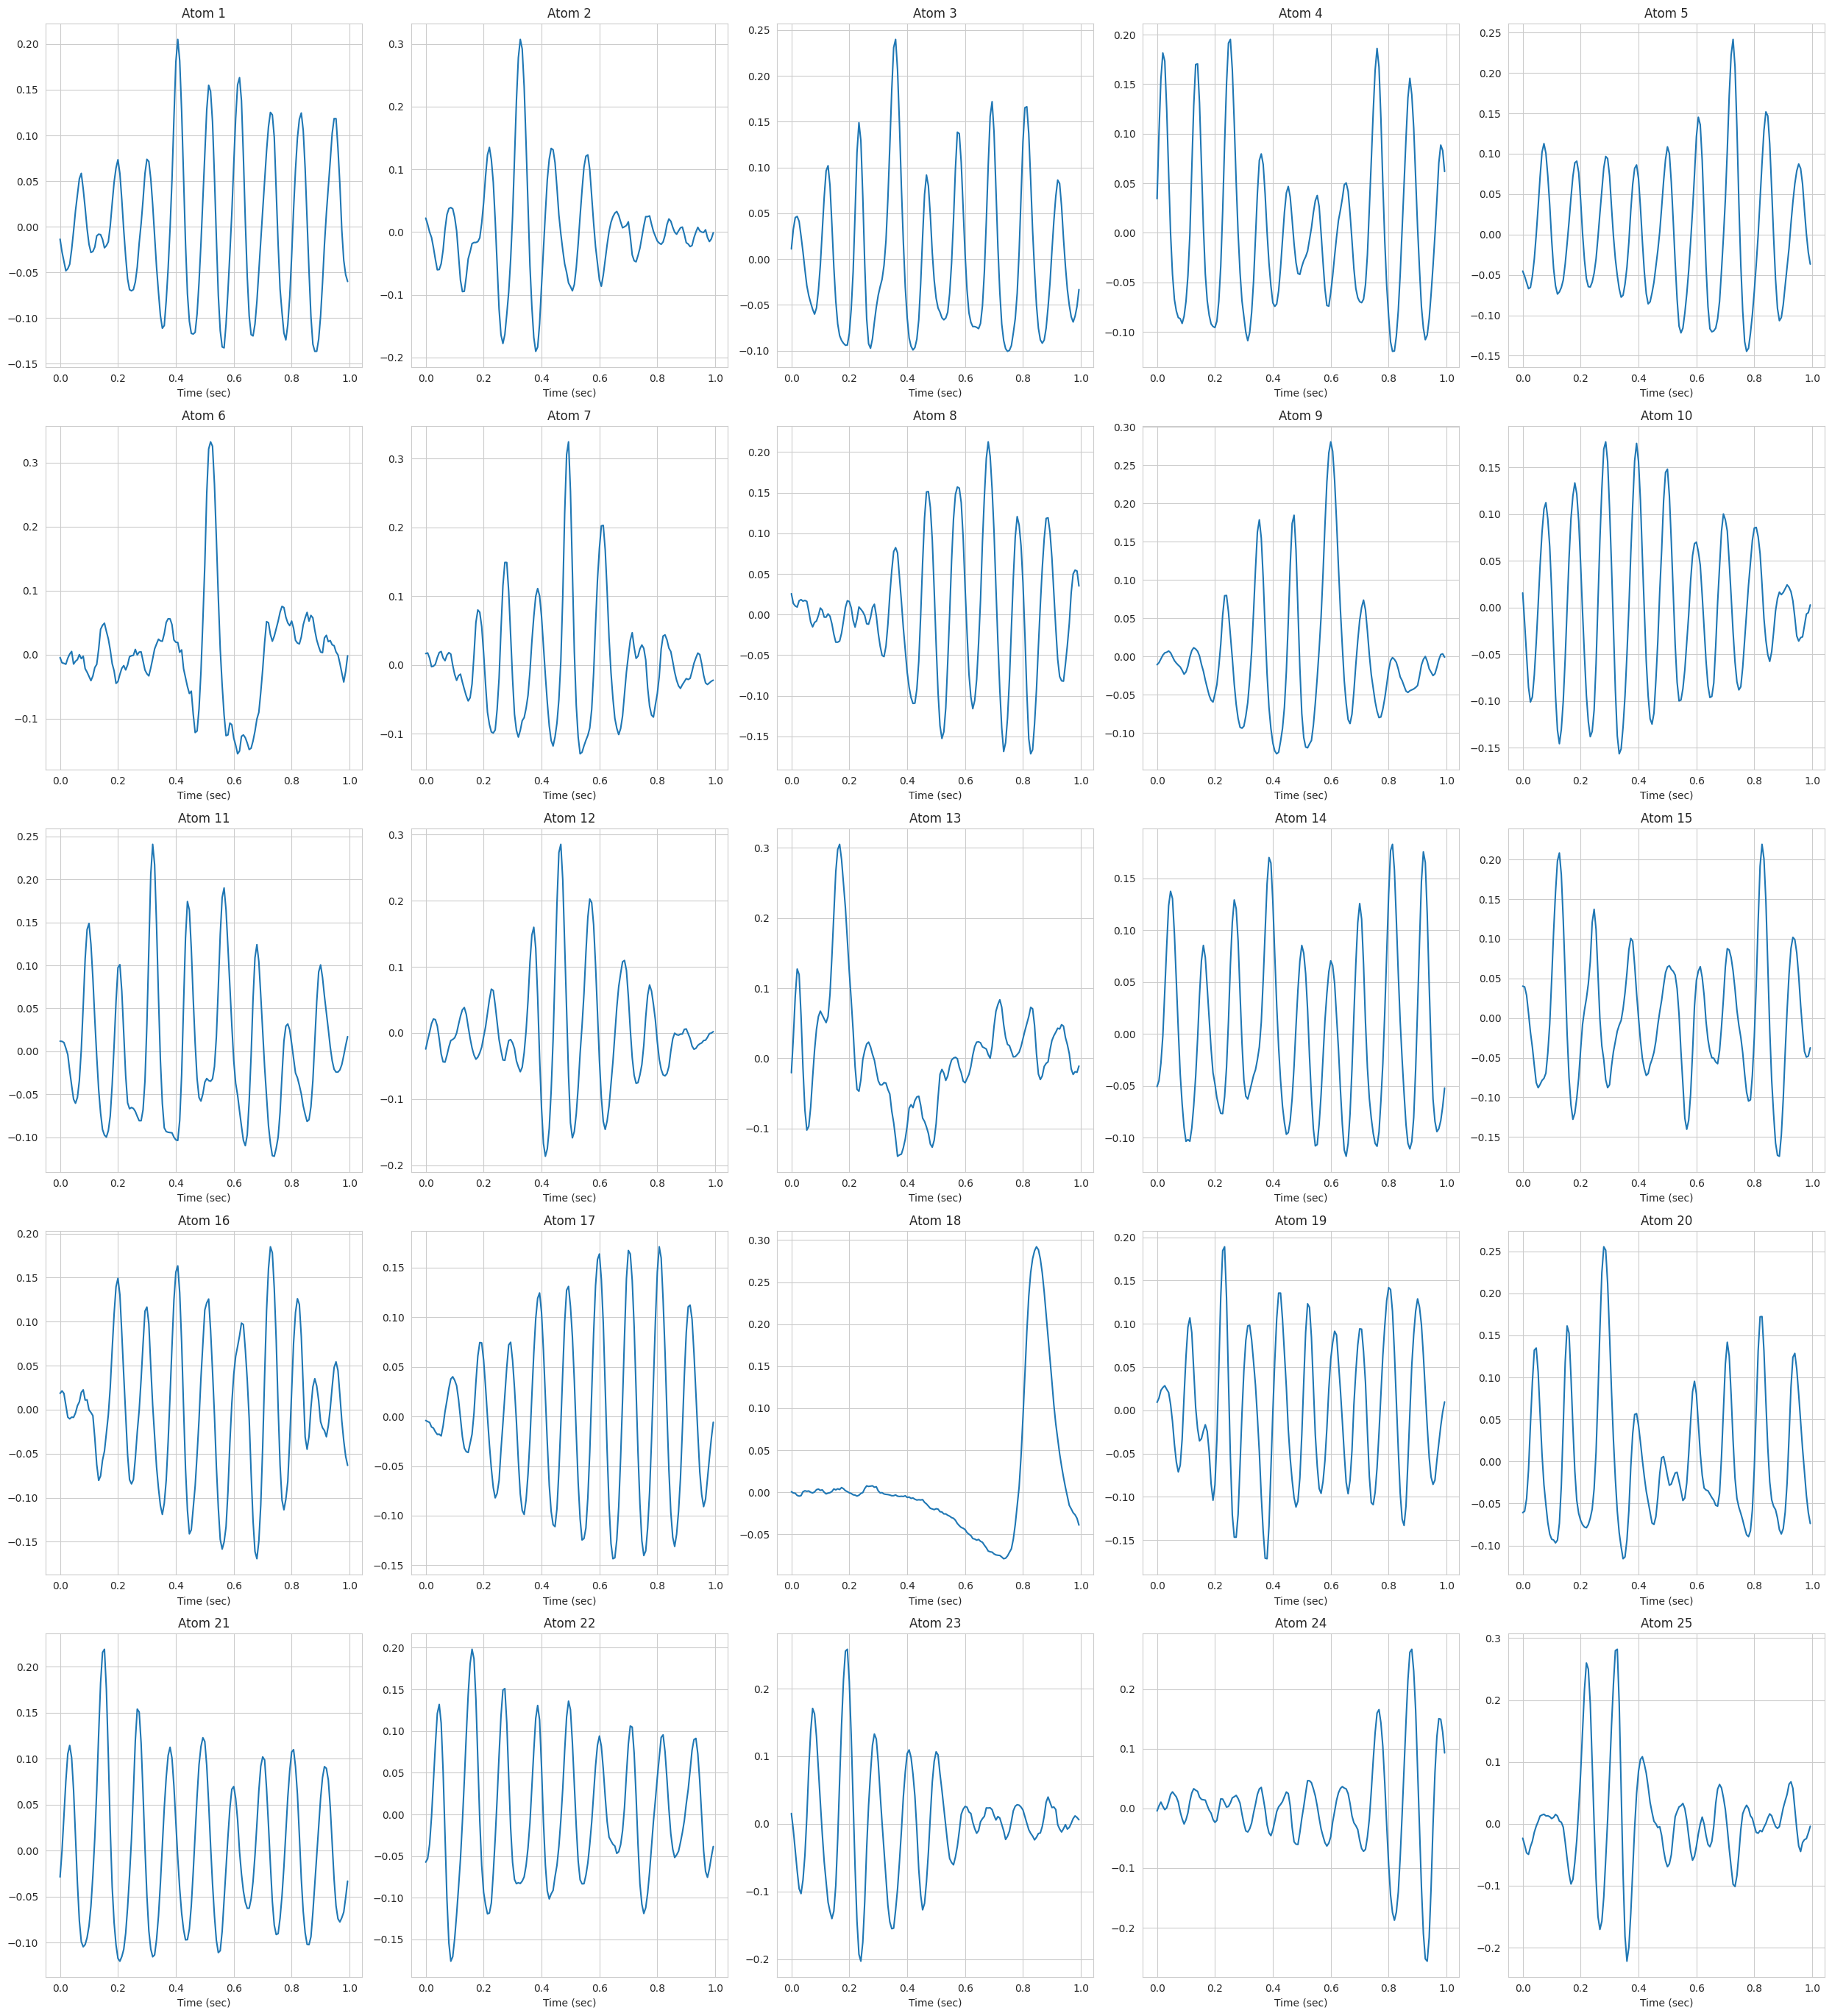

In [ ]:
# display all
display_atoms(cdl_all, n_atoms, 5, 5, sfreq)
display_ffts(cdl_all, n_atoms, 5, 5, sfreq)
display_topomap(cdl_all, n_atoms, 5, 5, info)

Now, let's separate the regions

In [ ]:
# Define the shape of the dictionary
n_atoms = 10
n_times_atom = int(round(sfreq * 1.0))  # 1000. ms

cdl = BatchCDL(
    # Shape of the dictionary
    n_atoms=n_atoms,
    n_times_atom=n_times_atom,
    # Request a rank1 dictionary with unit norm temporal and spatial maps
    rank1=True, uv_constraint='separate',
    # Initialize the dictionary with random chunk from the data
    D_init='chunk',
    # rescale the regularization parameter to be 20% of lambda_max
    lmbd_max="scaled", reg=.2,
    # Number of iteration for the alternate minimization and cvg threshold
    n_iter=100, eps=1e-4,
    # solver for the z-step
    solver_z="lgcd", solver_z_kwargs={'tol': 1e-2, 'max_iter': 1000},
    # solver for the d-step
    solver_d='alternate_adaptive', solver_d_kwargs={'max_iter': 300},
    # Technical parameters
    verbose=1, random_state=0, n_jobs=6)



In [ ]:
# Learn rank-1 atoms for each separate part of the brain

# Separate the problem into 2 different
cdl_1 = copy.deepcopy(cdl)
cdl_2 = copy.deepcopy(cdl)

cdl_1.fit(X1)
cdl_2.fit(X2)


We can see that, even in two different regions, there are few region-specific patterns, and most o the atoms found on each of the regions can be related to each other and to the atoms found when using all regions of the brain to train the CSC model.

In [ ]:
# Display the 4-th atom, which displays a :math:`\mu`-waveform in its temporal
# pattern.

display_atoms(cdl_1, n_atoms, 2, 5, sfreq, savefig="atoms_somato_1")
display_ffts(cdl_1, n_atoms, 2, 5, sfreq, savefig = "topomap_ffts_1")
display_topomap(cdl_1, n_atoms, 2, 5, info1, savefig = "topomap_somato_1")

display_atoms(cdl_2, n_atoms, 2, 5, sfreq, savefig="atoms_somato_2")
display_ffts(cdl_2, n_atoms, 2, 5, sfreq, savefig = "topomap_ffts_2")
display_topomap(cdl_2, n_atoms, 2, 5, info2, savefig = "topomap_somato_2")


In [ ]:
def distance(v_hat_1, v_hat_2, n1, n2):
    table=np.zeros(shape=(n1, n2))

    for i in range(n_atoms):
        align_row = []
        for j in range(i,n_atoms):

            alignment = dtw(v_hat_1[i], v_hat_2[j],keep_internals=True)
            align_row.append(alignment)
            table[i,j]=alignment.distance
            table[j,i]=alignment.distance
    return table

In [ ]:
# Compare the atoms found in the two regions

# Compute the dtw distance between atoms found on each region
v_hat_1 = cdl_1.v_hat_
v_hat_2 = cdl_2.v_hat_

table = distance(v_hat_1, v_hat_2, n_atoms, n_atoms)

columns = [f"Atom {i}" for i in range(1,1+n_atoms)]

min_index = np.argmin(table)
row, col = np.unravel_index(min_index, table.shape)

# Plot the most similar atoms
min_distance = table[row,col]
atom_row = v_hat_1[row]
atom_col = v_hat_2[col]

figsize = (11,5)
fig, axes = plt.subplots(1, 2, figsize=figsize, squeeze=False)

t = np.arange(atom_row.size)/sfreq

ax1 = axes[0,0]
ax1.plot(t, atom_row)
ax1.set(xlabel='Time (sec)', title=f'Atom {row + 1}')
ax1.grid(True)

ax2 = axes[0,1]
ax2.plot(t, atom_col)
ax2.set(xlabel='Time (sec)', title=f'Atom {col + 1}')
ax2.grid(True)

plt.tight_layout()
plt.savefig("../figures/most_similar_atoms.pdf", dpi=300)
plt.show()



In [ ]:
# Plot the distance between atoms

table_df = pd.DataFrame(table, columns=columns)
table_df.index = columns

fig, ax = plt.subplots()
sns.heatmap(table_df, annot=True, cmap="YlGnBu", linewidths=0.5, ax=ax)
plt.xticks(rotation=45)
plt.savefig("../figures/distance_atoms.pdf", dpi=300)
# Show the plot
plt.show()
